In [100]:
import torch
from torch.utils.data import DataLoader
from torchtext import datasets
from torch.utils.data.backward_compatibility import worker_init_fn

In [101]:
!pip install portalocker>=2.0.0

In [102]:
!pip show torch
!pip show torchtext
!pip show torchdata
!pip show portalocker

Name: torch
Version: 2.2.2
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchtext, torchvision
Name: torchtext
Version: 0.6.0
Summary: Text utilities and datasets for PyTorch
Home-page: https://github.com/pytorch/text
Author: PyTorch core devs and James Bradbury
Author-email: jekbradbury@gmail.com
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, requests, sentencepiece, six, torch, tqdm
Required-by: 
Name: torchdata
Ve

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import UDPOS
from torchtext.vocab import GloVe
import numpy as np
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator

In [9]:
!pip install torchtext==0.6


In [73]:
!pip show torchtext

Name: torchtext
Version: 0.6.0
Summary: Text utilities and datasets for PyTorch
Home-page: https://github.com/pytorch/text
Author: PyTorch core devs and James Bradbury
Author-email: jekbradbury@gmail.com
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, requests, sentencepiece, six, torch, tqdm
Required-by: 


In [74]:
import spacy
import torch
from torchtext.data import Field, BucketIterator
from torchtext.datasets import UDPOS

def tokenizer(text):
    return [tok.text for tok in nlp.tokenizer(text)]


TEXT = Field(tokenize=tokenizer, lower=True, include_lengths=True)
TAGS = Field(unk_token=None, is_target=True)


fields = [('text', TEXT), ('tags', TAGS)]


train_data, valid_data, test_data = UDPOS.splits(fields=fields)


TEXT.build_vocab(train_data, max_size=10000, min_freq=2)
TAGS.build_vocab(train_data)
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=32,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))





In [75]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.output_dim = output_dim

    def forward(self, text, text_lengths):

        embedded = self.dropout(self.embedding(text))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, _ = self.lstm(packed_embedded)

        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output)

        output = self.fc(self.dropout(output))
        return output


In [95]:
from torchtext.vocab import GloVe
from torchtext.data import Field, BucketIterator
from torchtext.datasets import UDPOS


TEXT = Field(lower=True, include_lengths=True)
UD_TAGS = Field(unk_token=None, is_target=True)


fields = [('text', TEXT), ('udtags', UD_TAGS)]
train_data, valid_data, test_data = UDPOS.splits(fields=fields)


TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=100))
UD_TAGS.build_vocab(train_data)


INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(UD_TAGS.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25


model = BiLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)


model.embedding.weight.data.copy_(TEXT.vocab.vectors)


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2634,  0.0742, -0.1081,  ..., -0.2977, -0.5655,  0.5218],
        [ 0.4244,  0.6004, -0.1528,  ...,  0.2536, -0.4969,  0.8964]])

In [96]:
import torch
import os
from torch import optim, nn

def initialize_optimizer_and_criterion(model):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    return optimizer, criterion

def calculate_accuracy(predictions, labels):
    correct = (predictions.argmax(dim=1) == labels).float()
    return correct.mean()

def train_epoch(model, iterator, optimizer, criterion):
    model.train()
    total_loss = 0
    total_accuracy = 0
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        tags = batch.udtags.view(-1)
        predictions = model(text, text_lengths).view(-1, model.output_dim)
        loss = criterion(predictions, tags)
        acc = calculate_accuracy(predictions, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += acc.item()
    return total_loss / len(iterator), total_accuracy / len(iterator)

def evaluate_model(model, iterator, criterion):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            tags = batch.udtags.view(-1)
            predictions = model(text, text_lengths).view(-1, model.output_dim)
            loss = criterion(predictions, tags)
            acc = calculate_accuracy(predictions, tags)
            total_loss += loss.item()
            total_accuracy += acc.item()
    return total_loss / len(iterator), total_accuracy / len(iterator)

def save_checkpoint(state, filename="model_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def train_model(model, train_iterator, valid_iterator, num_epochs, model_path='best_model.pt'):
    optimizer, criterion = initialize_optimizer_and_criterion(model)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_valid_accuracy = 0.0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate_model(model, valid_iterator, criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(valid_loss)
        history['val_acc'].append(valid_acc)

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}')
        print(f'\tValid Loss: {valid_loss:.3f}, Valid Acc: {valid_acc:.3f}')

        if valid_acc > best_valid_accuracy:
            best_valid_accuracy = valid_acc
            torch.save(model.state_dict(), model_path)
            save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'valid_acc': valid_acc})

    print("Training completed.")
    return history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=64,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device
)

NUM_EPOCHS = 10
history = train_model(model, train_iterator, valid_iterator, NUM_EPOCHS, 'best_model.pt')




Epoch: 01
	Train Loss: 1.092, Train Acc: 0.680
	Valid Loss: 0.644, Valid Acc: 0.869
=> Saving checkpoint
Epoch: 02
	Train Loss: 0.436, Train Acc: 0.884
	Valid Loss: 0.539, Valid Acc: 0.883
=> Saving checkpoint
Epoch: 03
	Train Loss: 0.322, Train Acc: 0.918
	Valid Loss: 0.511, Valid Acc: 0.891
=> Saving checkpoint
Epoch: 04
	Train Loss: 0.262, Train Acc: 0.936
	Valid Loss: 0.483, Valid Acc: 0.896
=> Saving checkpoint
Epoch: 05
	Train Loss: 0.224, Train Acc: 0.950
	Valid Loss: 0.460, Valid Acc: 0.904
=> Saving checkpoint
Epoch: 06
	Train Loss: 0.185, Train Acc: 0.958
	Valid Loss: 0.470, Valid Acc: 0.905
=> Saving checkpoint
Epoch: 07
	Train Loss: 0.164, Train Acc: 0.964
	Valid Loss: 0.456, Valid Acc: 0.908
=> Saving checkpoint
Epoch: 08
	Train Loss: 0.143, Train Acc: 0.968
	Valid Loss: 0.472, Valid Acc: 0.906
Epoch: 09
	Train Loss: 0.144, Train Acc: 0.972
	Valid Loss: 0.457, Valid Acc: 0.911
=> Saving checkpoint
Epoch: 10
	Train Loss: 0.126, Train Acc: 0.975
	Valid Loss: 0.465, Valid Acc

In [114]:

def eval_test(model, data_iterator, loss_metric):
    model.eval()
    total_test_loss = 0
    total_test_accuracy = 0

    with torch.no_grad():
        for data in data_iterator:
            input_text, lengths_of_text = data.text
            ground_truth_labels = data.udtags

            predictions = model(input_text, lengths_of_text).view(-1, OUTPUT_DIM)
            ground_truth_labels = ground_truth_labels.view(-1)

            loss = loss_metric(predictions, ground_truth_labels)
            accuracy = compute_accuracy(predictions, ground_truth_labels)

            total_test_loss += loss.item()
            total_test_accuracy += accuracy.item()

    mean_loss = total_test_loss / len(data_iterator)
    mean_accuracy = total_test_accuracy / len(data_iterator)
    return mean_loss, mean_accuracy

def compute_accuracy(predictions, true_labels):
    """ Calculate the accuracy based on the maximum probability predictions and true labels. """
    correct_predictions = predictions.argmax(dim=1, keepdim=True).squeeze(1).eq(true_labels)
    return correct_predictions.float().mean()

# Load the pretrained model
model_path = 'best_model.pt'
model.load_state_dict(torch.load(model_path))

# Evaluate the model on the test data
test_data_loss, test_data_accuracy = eval_test(model, test_iterator, criterion)
print(f'Model Evaluation on Test Data - Loss: {test_data_loss:.3f}, Accuracy: {test_data_accuracy * 100:.2f}%')


Model Evaluation on Test Data - Loss: 0.448, Accuracy: 90.66%


In [ ]:
import torch
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_model(model_path, model):
    """ Load the model from a file. """
    try:
        model.load_state_dict(torch.load(model_path))
        model.eval()
    except FileNotFoundError:
        logging.error(f"Model file not found: {model_path}")
        exit(1)
    except Exception as e:
        logging.error(f"Error loading model: {str(e)}")
        exit(1)

def calculate_accuracy(predictions, tags):
    """ Calculate the accuracy of predictions. """
    max_preds = predictions.argmax(dim=1, keepdim=True)  # get the index of the max probability
    correct = max_preds.squeeze(1).eq(tags)
    return correct.sum() / torch.FloatTensor([tags.shape[0]])

def evaluate_test(model, iterator, criterion, output_dim):
    """ Evaluate the model on a test set. """
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            tags = batch.udtags

            predictions = model(text, text_lengths).view(-1, output_dim)
            tags = tags.view(-1)

            loss = criterion(predictions, tags)
            acc = calculate_accuracy(predictions, tags)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Parameters
model_path = 'best_model.pt'
output_dim = 100  # Assuming OUTPUT_DIM is 100, this should be defined based on your model's architecture

# Load the model and evaluate on the test dataset
load_model(model_path, model)
test_loss, test_acc = evaluate_test(model, test_iterator, criterion, output_dim)
logging.info(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


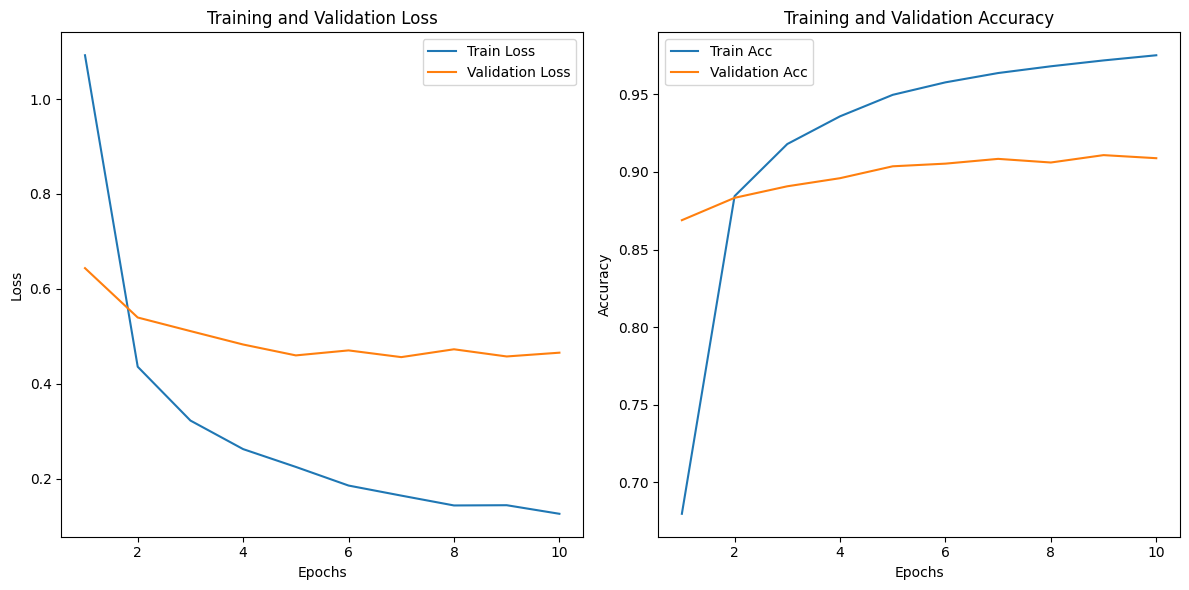

In [97]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [111]:
def tag_sentence(sentence, model, vocab, tag_vocab):

    nlp = spacy.load('en_core_web_sm')

    tokens = [tok.text for tok in nlp(sentence)]


    token_indices = [vocab.stoi.get(token.lower(), vocab.stoi['<unk>']) for token in tokens]


    token_tensor = torch.LongTensor(token_indices).unsqueeze(0)

    lengths = torch.LongTensor([len(token_indices)])


    model.eval()
    with torch.no_grad():

        embedded = model.embedding(token_tensor)
        packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = model.lstm(packed_embedded)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)


        predictions = model.fc(model.dropout(output))
        predicted_indices = torch.argmax(predictions, dim=2).squeeze(0).tolist()


    predicted_tags = [tag_vocab.itos[idx] for idx in predicted_indices]


    tagged_sentence = ' '.join([f'{token}/{tag}' for token, tag in zip(tokens, predicted_tags)])
    return tagged_sentence


sentences = [
    "The old man the boat.",
    "The complex houses married and single soldiers and their families.",
    "The man who hunts ducks out on weekends."
]

vocab = TEXT.vocab
tag_vocab = TAGS.vocab

for sentence in sentences:
    print(tag_sentence(sentence, model, vocab, tag_vocab))


The/DET old/ADJ man/NOUN the/DET boat/NOUN ./PUNCT
The/DET complex/ADJ houses/NOUN married/VERB and/CCONJ single/ADJ soldiers/NOUN and/CCONJ their/PRON families/NOUN ./PUNCT
The/DET man/NOUN who/PRON hunts/VERB ducks/VERB out/ADP on/ADP weekends/NOUN ./PUNCT
